In [1]:
# Imports
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

torch.cuda.empty_cache()
device = torch.device("cuda")

In [2]:
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 10
train_size = 0.8

train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size)

In [3]:
model = CustomResNet(num_classes=2).to(device)
# Load the weights
model.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))

model_regularized_l1 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l1.load_state_dict(torch.load(f"../models/vess_map_regularized_l1_200.pth"))

model_regularized_l2 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l2.load_state_dict(torch.load(f"../models/vess_map_regularized_l2_200.pth"))

model = model.eval()
model_regularized_l1 = model_regularized_l1.eval()
model_regularized_l2 = model_regularized_l2.eval()

In [4]:
# Select a random batch from the test dataset
images, masks, skeletons = next(iter(test_loader))

images, masks, skeletons = images.to(device), masks.to(device), skeletons.to(device)

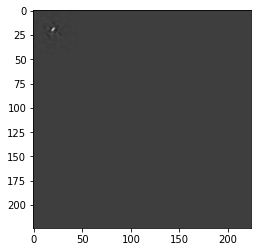

In [5]:
# Getting ONE gradient
input_image = images[2].unsqueeze(0)
input_image.requires_grad_()  # Ensure gradients are tracked for input_image

out = model(input_image)

x = 20
y = 20
score = out[0, 1, x, y]

score.backward()  # invoke backward to compute gradients

# Access the gradients from input_image, not from 'out'
gradient = input_image.grad

plt.imshow(gradient[0, 0, :, :].detach().cpu().numpy(), cmap='gray')

In [6]:
def positive_score(out, target = 1):
  search_domain = out[0, :, :]
  
  for i in range(100, search_domain.shape[0]):
        for j in range(100, search_domain.shape[1]):
            if search_domain[i, j] > 0:
                return (i, j)
  return None

def compute_gradient_at_coordinates(model, image, skeleton, coordinates_array):
    # Ensure image requires gradient
    image = image.unsqueeze(0).requires_grad_()

    # Forward pass
    out = model(image)

    # Get the score at the specified coordinates for class 1
    x, y = positive_score(skeleton, 1)
    coordinates_array.append((x, y))
    
    score = out[0, 1, x, y]

    # Compute gradients
    score.backward()

    # Return the gradient
    return image.grad
  

def compute_softmax_gradient(model, image, skeleton, coordinates_array):
    # Ensure image requires gradient
    image = image.unsqueeze(0).requires_grad_()

    # Forward pass
    out = model(image)

    # Apply softmax to the output to get class probabilities
    probabilities = F.softmax(out, dim=1)

    # Get the score at the specified coordinates_array for class 1
    x, y = positive_score(skeleton, 1)
    coordinates_array.append((x, y))
    score = probabilities[0, 1, x, y]  # Probability of class 1 at (x, y)

    # Compute gradients
    score.backward()

    # Return the gradient
    return image.grad


(0.0, 224.0)

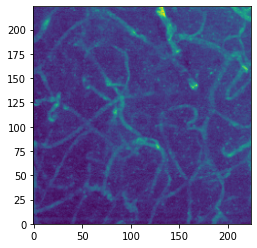

In [7]:
plt.imshow(images[0,0].detach().cpu().numpy())
plt.ylim((0, 224))

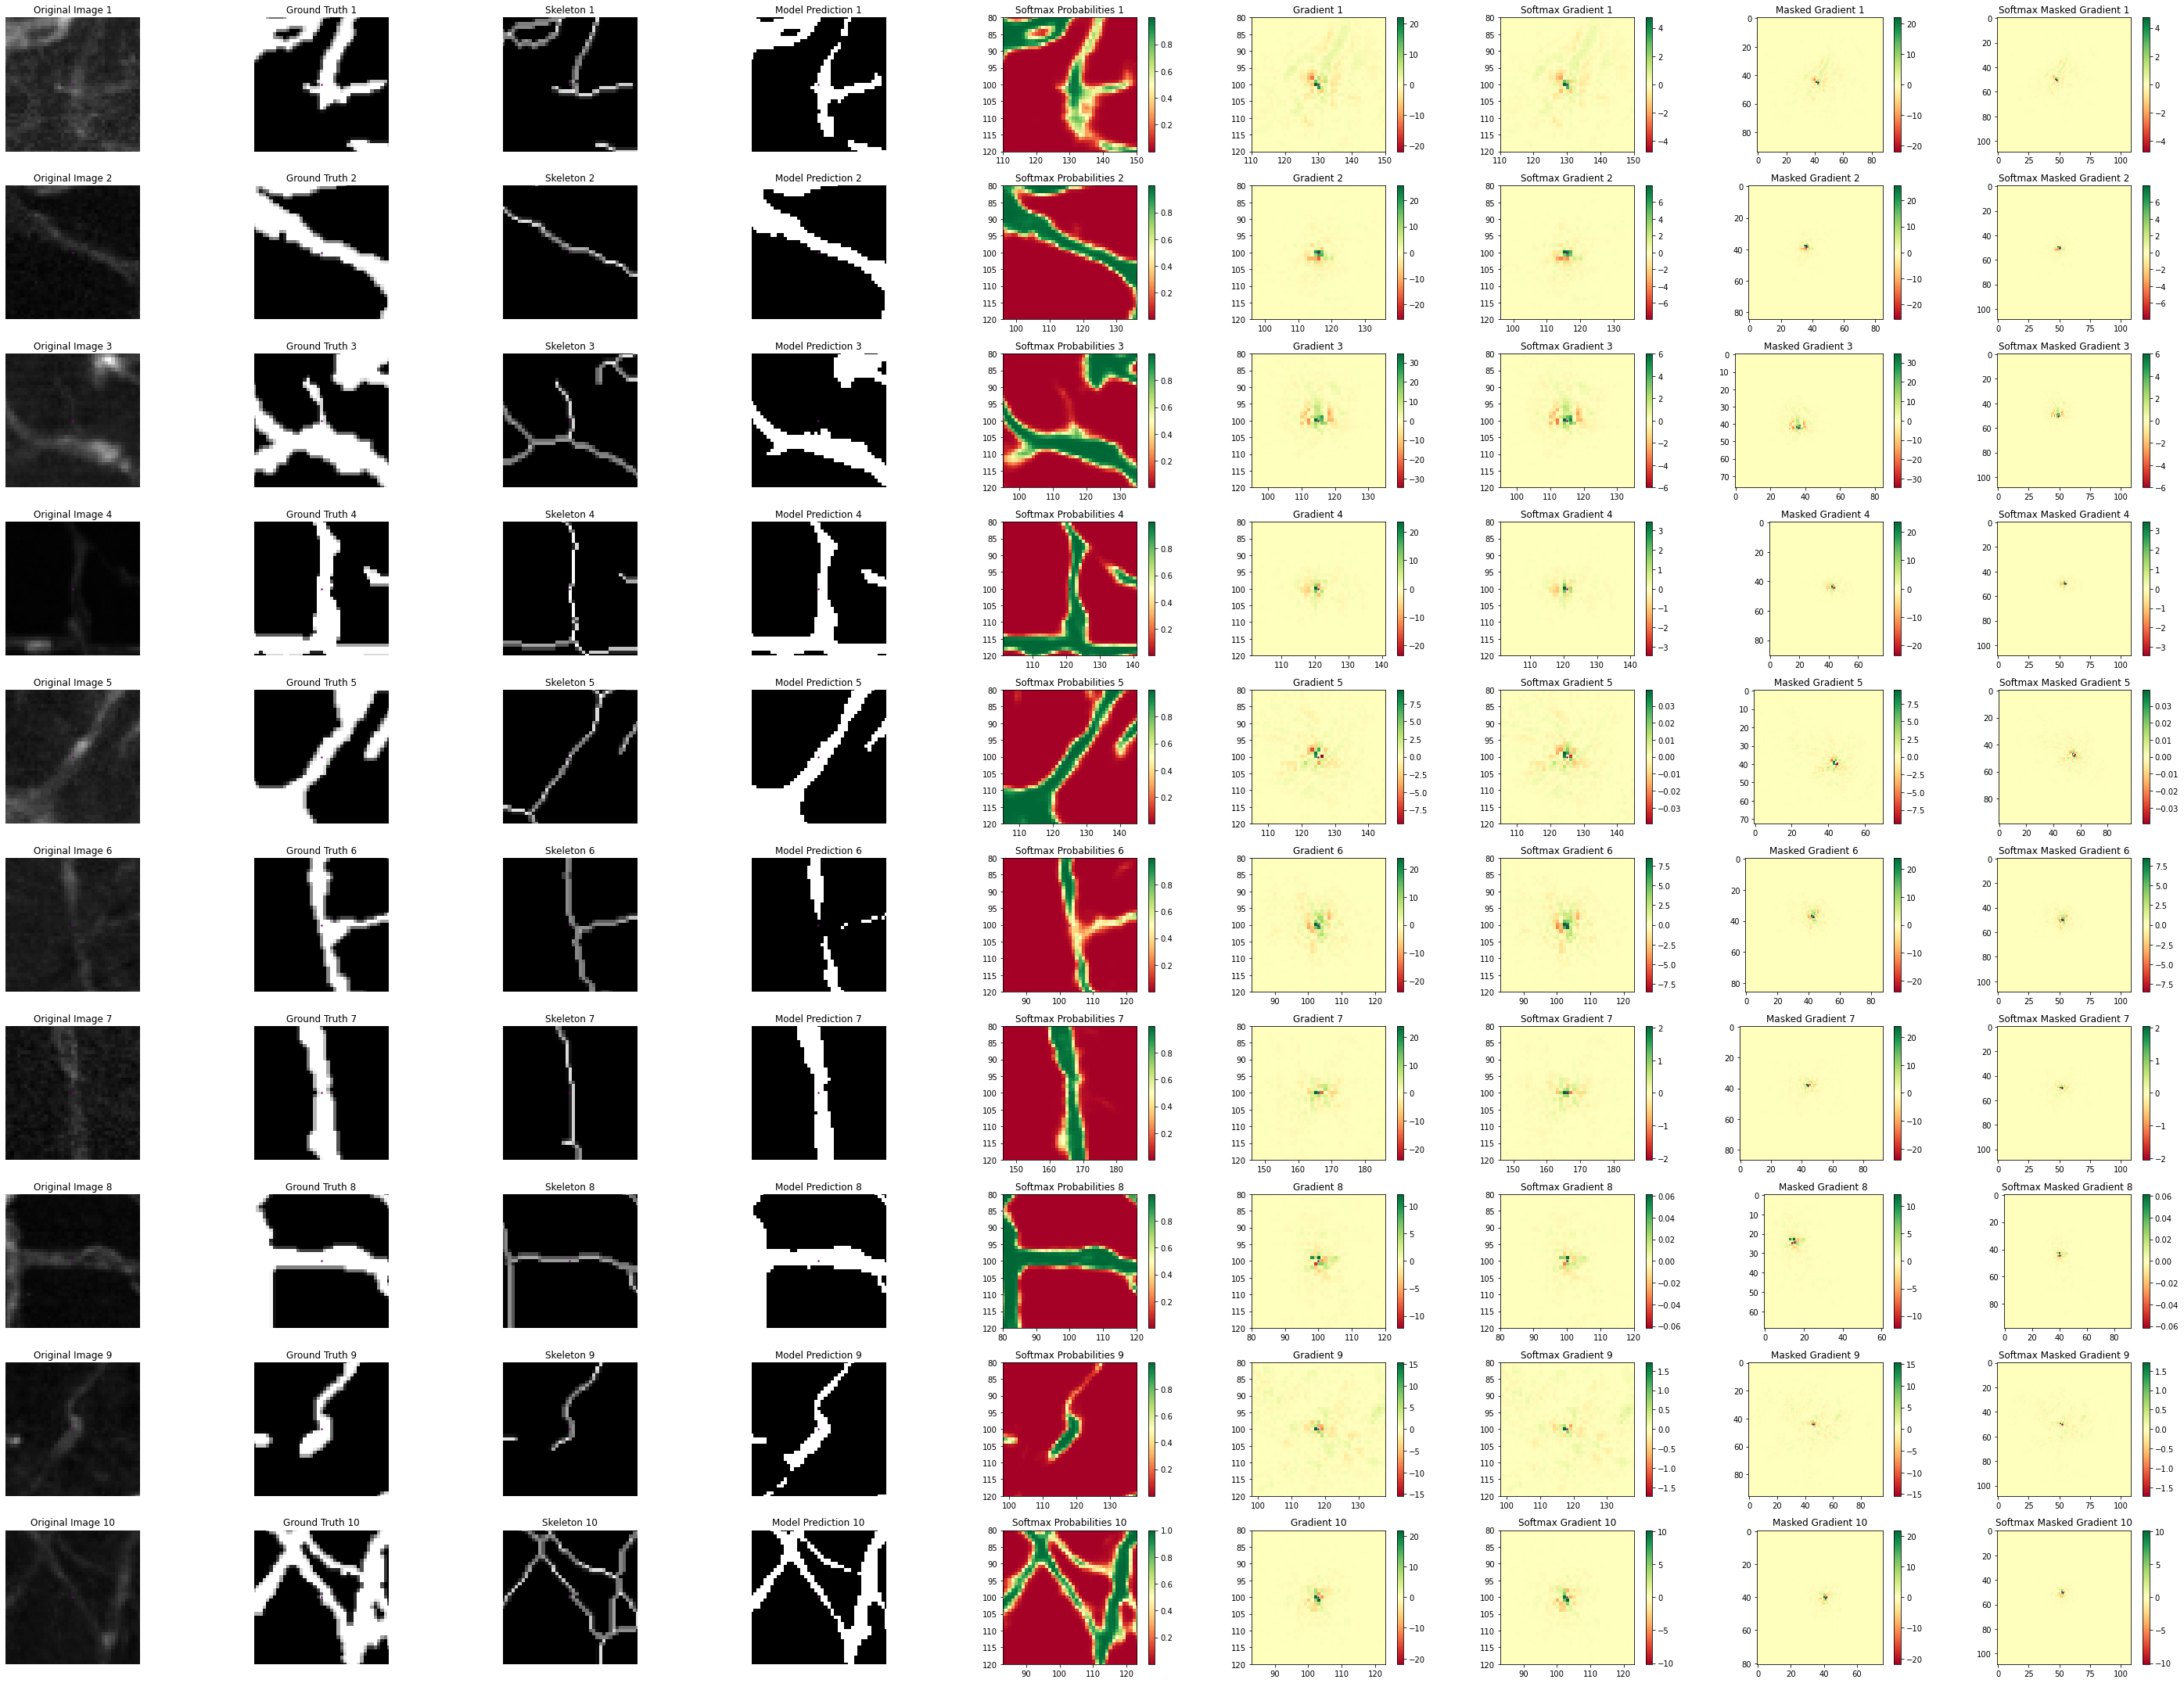

In [8]:
coordinates = []
soft_coordinates = []
# Iterate over all images
gradients = []
softmax_gradients = []
for i, img in enumerate(images):
    # Compute the gradient at the specified coordinates
    softmax_gradients.append(compute_softmax_gradient(model, img, skeletons[i], soft_coordinates))
    gradients.append(compute_gradient_at_coordinates(model, img, skeletons[i], coordinates))
    

num_images = len(gradients)

threshold = 0.1
soft_threshold = 0.0001


# Create a figure with 5 columns for each image: gradient, binary array, original image, and model output
fig, axes = plt.subplots(num_images, 9, figsize=(num_images * 4, num_images * 3))

for i in range(num_images):
    # Original Image Visualization
    original_img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    
    
    # Original Mask Visualization
    original_mask = masks[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 1].imshow(original_mask, cmap='gray')
    axes[i, 1].set_title(f'Ground Truth {i+1}')
    
    # Original Skeleton Visualization
    original_ske = skeletons[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 2].imshow(original_ske, cmap='gray')
    axes[i, 2].set_title(f'Skeleton {i+1}')
    

    # Model (Mask)Output Visualization
    output = model_regularized_l2(images[i].unsqueeze(0))  
    out_max = torch.argmax(output, dim=1, keepdim=True)
    model_mask = out_max[0].detach().cpu().numpy()
    axes[i, 3].imshow(model_mask.transpose(1, 2, 0), cmap='gray')
    axes[i, 3].set_title(f'Model Prediction {i+1}')
    
    # Softmax Probabilities Visualization
    output = model(images[i].unsqueeze(0))  
    softmax_probs = F.softmax(output, dim=1)
    class_one_probs = softmax_probs[0, 1, :, :].detach().cpu().numpy()
    img_softmax = axes[i, 4].imshow(class_one_probs, cmap='RdYlGn', interpolation='nearest')
    axes[i, 4].set_title(f'Softmax Probabilities {i+1}')
    
    # Gradient Visualization
    gradient = gradients[i].squeeze()
    v_max = np.abs(gradient.detach().cpu().numpy()).max()

    img_grad = axes[i, 5].imshow(gradient.detach().cpu().numpy(), cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 5].set_title(f'Gradient {i+1}')
    
    
    # Softmax Gradient Visualization
    softmax_gradient = softmax_gradients[i].squeeze()
    v_max = np.abs(softmax_gradient.detach().cpu().numpy()).max()

    soft_img_grad = axes[i, 6].imshow(softmax_gradient.detach().cpu().numpy(), cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 6].set_title(f'Softmax Gradient {i+1}')
    
    
    # Create a mask where gradient values are above the threshold
    mask = np.abs(gradient.detach().cpu().numpy()) > threshold
    # Find the bounds of the relevant region
    non_zero_coords = np.nonzero(mask)
    # Getting coordinates
    y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
    x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
    relevant_region = gradient[y_min:y_max+1, x_min:x_max+1].detach().cpu().numpy()
    v_max = np.abs(relevant_region).max()
    img_masked_grad = axes[i, 7].imshow(relevant_region, cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 7].set_title(f'Masked Gradient {i+1}')


    # Create a mask where gradient values are above the threshold
    soft_mask = np.abs(softmax_gradient.detach().cpu().numpy()) > soft_threshold
    # Find the bounds of the relevant region
    soft_non_zero_coords = np.nonzero(soft_mask)
    # Getting coordinates
    soft_y_min, soft_y_max = soft_non_zero_coords[0].min(), soft_non_zero_coords[0].max()
    soft_x_min, soft_x_max = soft_non_zero_coords[1].min(), soft_non_zero_coords[1].max()
    soft_relevant_region = softmax_gradient[soft_y_min:soft_y_max+1, soft_x_min:soft_x_max+1].detach().cpu().numpy()
    soft_v_max = np.abs(soft_relevant_region).max()
    soft_img_masked_grad = axes[i, 8].imshow(soft_relevant_region, cmap='RdYlGn', vmin=-soft_v_max, vmax=soft_v_max, interpolation='nearest')
    axes[i, 8].set_title(f'Softmax Masked Gradient {i+1}')

    # Highlight the specified pixel and zoom in
    coord = coordinates[i]
    for ax in axes[i, :7]:
        ax.scatter(coord[1], coord[0], color='purple', s=2)
        ax.set_xlim((coord[1] - 20, coord[1] + 20))
        ax.set_ylim((coord[0] + 20, coord[0] - 20))

    for ax in axes[i, :4]:
        ax.axis('off')
        
    # Scatter on masked gradient
    soft_coord = soft_coordinates[i]
    axes[i, 7].scatter(coord[1] - x_min, coord[0] - y_min, color='purple', s=2)
    axes[i, 8].scatter(soft_coord[1] - soft_x_min, soft_coord[0] - soft_y_min, color='purple', s=2)
    
    
    # Add colorbars
    fig.colorbar(img_softmax, ax=axes[i, 4], orientation='vertical')
    fig.colorbar(img_grad, ax=axes[i, 5], orientation='vertical')
    fig.colorbar(soft_img_grad, ax=axes[i, 6], orientation='vertical')
    fig.colorbar(img_masked_grad, ax=axes[i, 7], orientation='vertical')
    fig.colorbar(soft_img_masked_grad, ax=axes[i, 8], orientation='vertical')
    
plt.tight_layout()
plt.show()

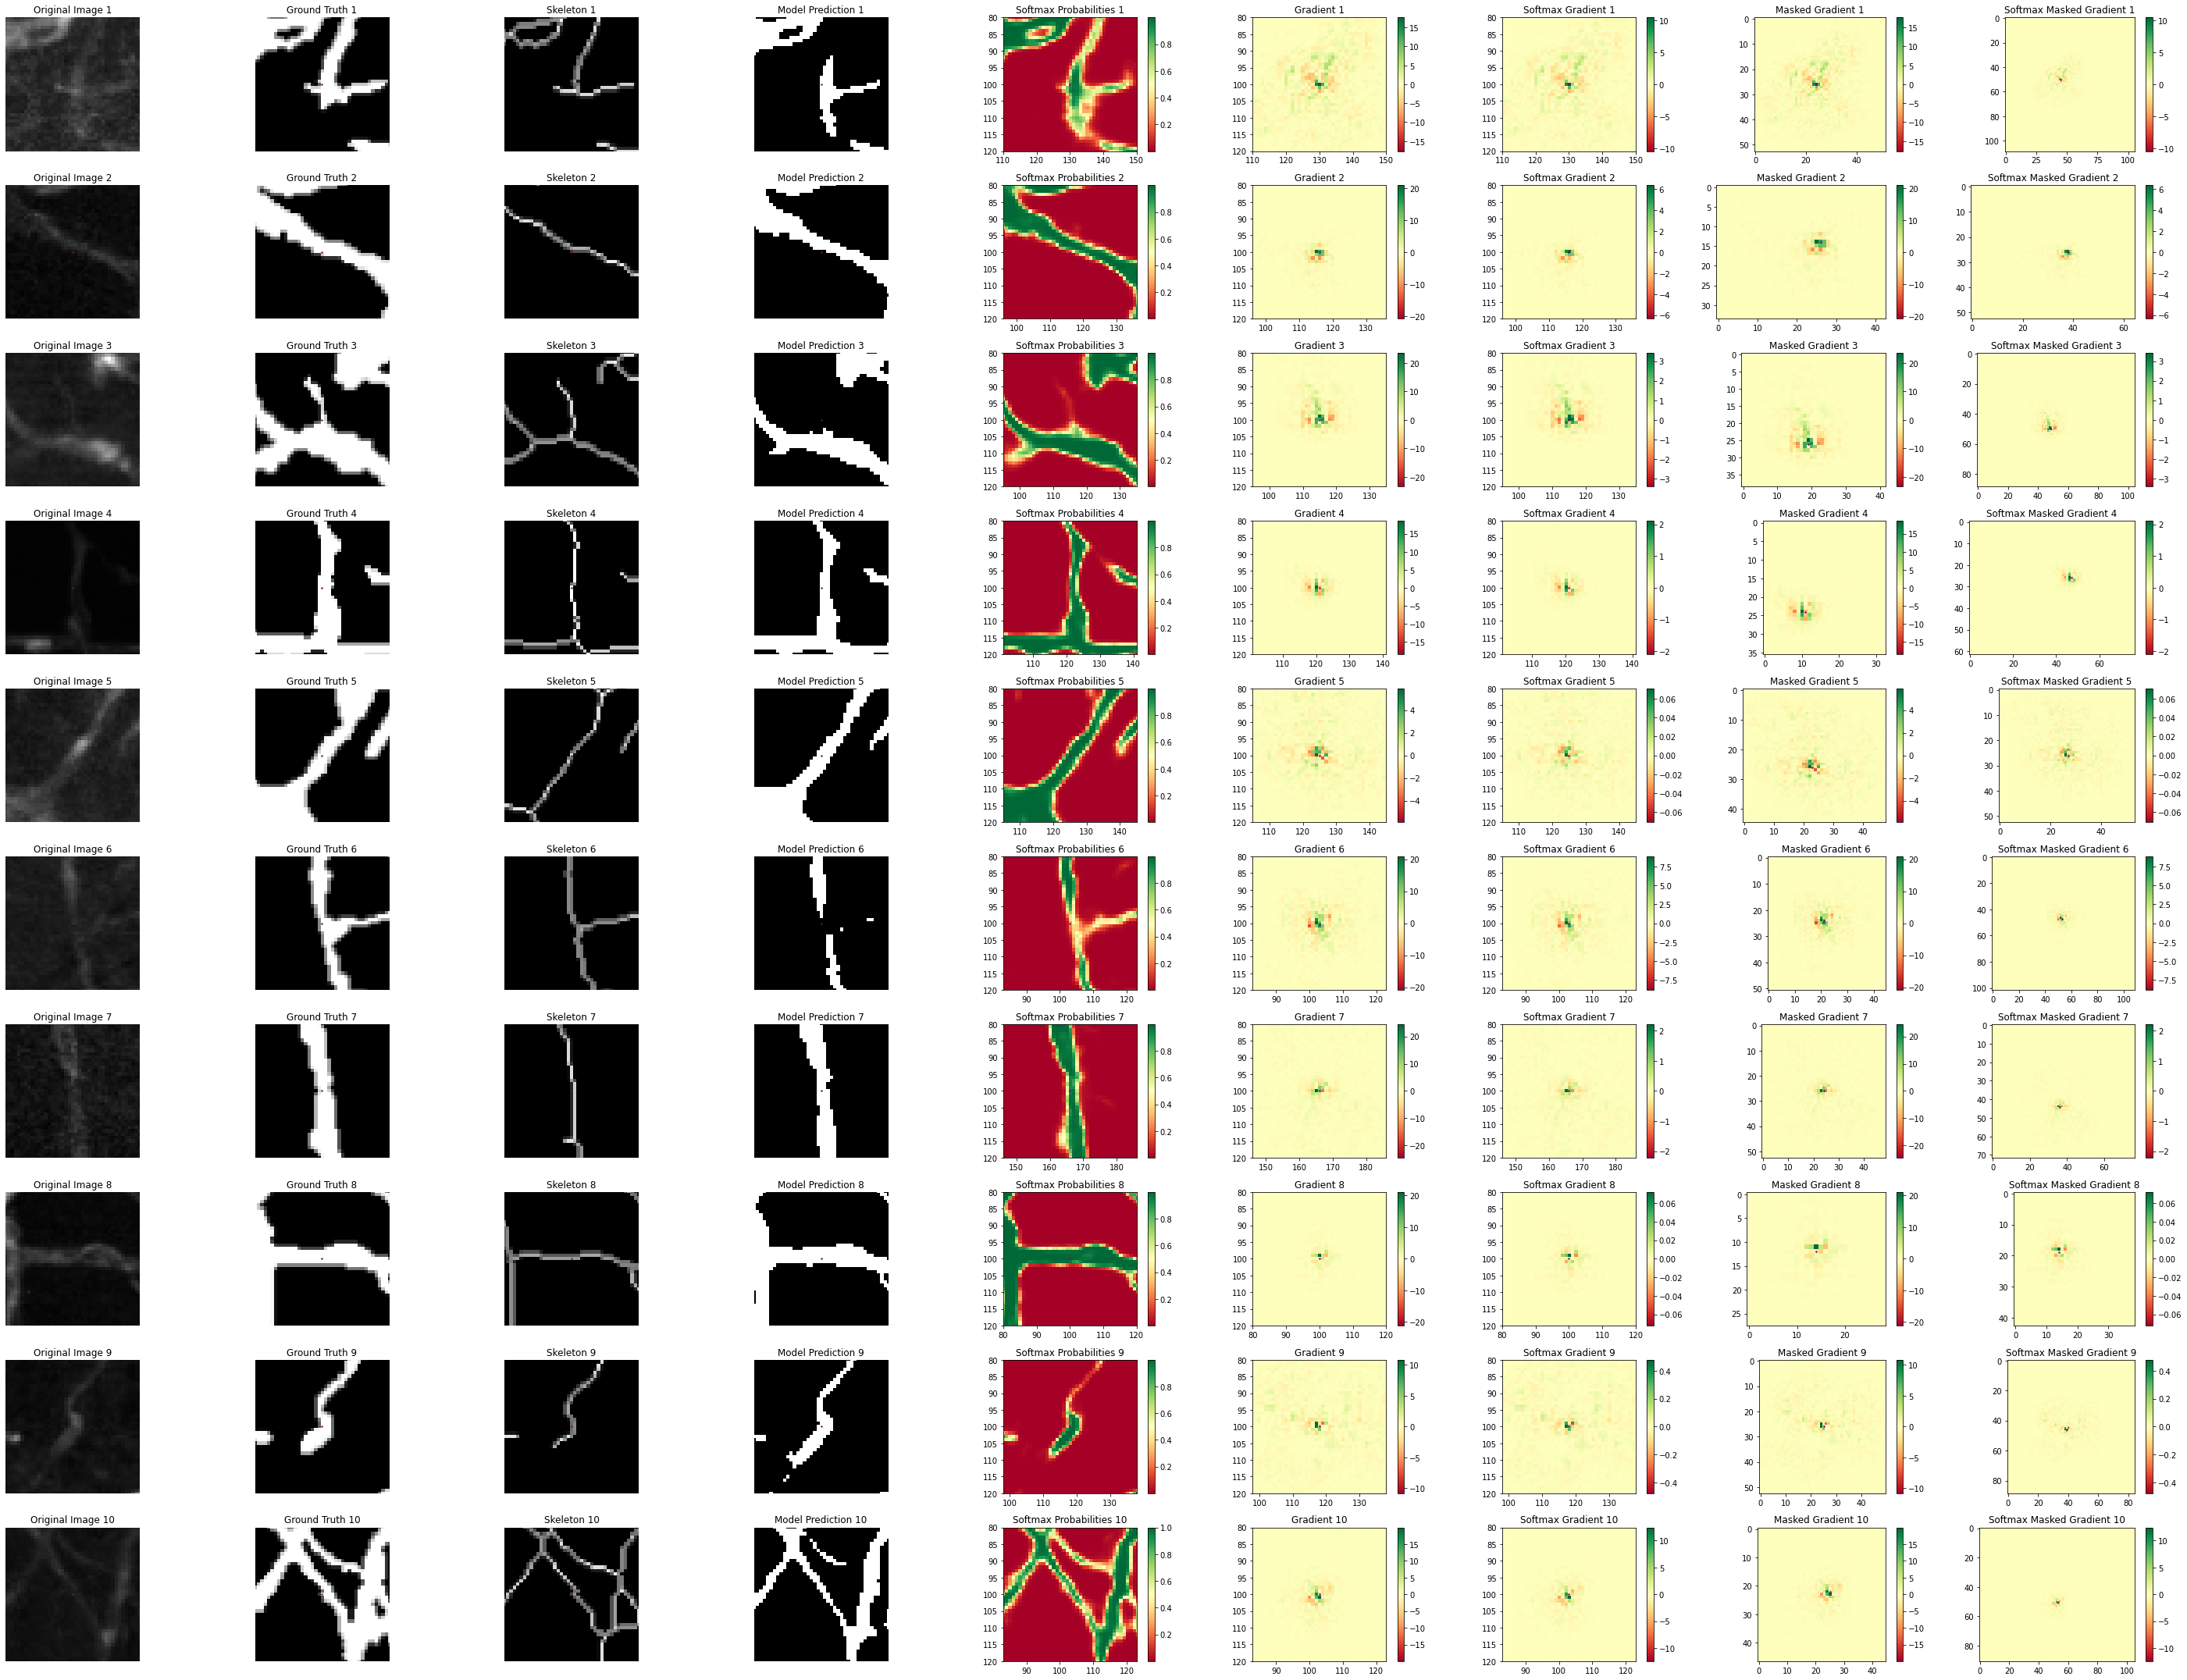

In [9]:
coordinates = []
soft_coordinates = []
# Iterate over all images
gradients = []
softmax_gradients = []
for i, img in enumerate(images):
    # Compute the gradient at the specified coordinates
    softmax_gradients.append(compute_softmax_gradient(model_regularized_l1, img, skeletons[i], soft_coordinates))
    gradients.append(compute_gradient_at_coordinates(model_regularized_l1, img, skeletons[i], coordinates))
    

num_images = len(gradients)

threshold = 0.1
soft_threshold = 0.0001


# Create a figure with 5 columns for each image: gradient, binary array, original image, and model output
fig, axes = plt.subplots(num_images, 9, figsize=(num_images * 4, num_images * 3))

for i in range(num_images):
    # Original Image Visualization
    original_img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    
    
    # Original Mask Visualization
    original_mask = masks[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 1].imshow(original_mask, cmap='gray')
    axes[i, 1].set_title(f'Ground Truth {i+1}')
    
    # Original Skeleton Visualization
    original_ske = skeletons[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 2].imshow(original_ske, cmap='gray')
    axes[i, 2].set_title(f'Skeleton {i+1}')
    

    # Model (Mask)Output Visualization
    output = model_regularized_l1(images[i].unsqueeze(0))  
    out_max = torch.argmax(output, dim=1, keepdim=True)
    model_mask = out_max[0].detach().cpu().numpy()
    axes[i, 3].imshow(model_mask.transpose(1, 2, 0), cmap='gray')
    axes[i, 3].set_title(f'Model Prediction {i+1}')
    
    # Softmax Probabilities Visualization
    output = model(images[i].unsqueeze(0))  
    softmax_probs = F.softmax(output, dim=1)
    class_one_probs = softmax_probs[0, 1, :, :].detach().cpu().numpy()
    img_softmax = axes[i, 4].imshow(class_one_probs, cmap='RdYlGn', interpolation='nearest')
    axes[i, 4].set_title(f'Softmax Probabilities {i+1}')
    
    # Gradient Visualization
    gradient = gradients[i].squeeze()
    v_max = np.abs(gradient.detach().cpu().numpy()).max()

    img_grad = axes[i, 5].imshow(gradient.detach().cpu().numpy(), cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 5].set_title(f'Gradient {i+1}')
    
    
    # Softmax Gradient Visualization
    softmax_gradient = softmax_gradients[i].squeeze()
    v_max = np.abs(softmax_gradient.detach().cpu().numpy()).max()

    soft_img_grad = axes[i, 6].imshow(softmax_gradient.detach().cpu().numpy(), cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 6].set_title(f'Softmax Gradient {i+1}')
    
    
    # Create a mask where gradient values are above the threshold
    mask = np.abs(gradient.detach().cpu().numpy()) > threshold
    # Find the bounds of the relevant region
    non_zero_coords = np.nonzero(mask)
    # Getting coordinates
    y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
    x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
    relevant_region = gradient[y_min:y_max+1, x_min:x_max+1].detach().cpu().numpy()
    v_max = np.abs(relevant_region).max()
    img_masked_grad = axes[i, 7].imshow(relevant_region, cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 7].set_title(f'Masked Gradient {i+1}')


    # Create a mask where gradient values are above the threshold
    soft_mask = np.abs(softmax_gradient.detach().cpu().numpy()) > soft_threshold
    # Find the bounds of the relevant region
    soft_non_zero_coords = np.nonzero(soft_mask)
    # Getting coordinates
    soft_y_min, soft_y_max = soft_non_zero_coords[0].min(), soft_non_zero_coords[0].max()
    soft_x_min, soft_x_max = soft_non_zero_coords[1].min(), soft_non_zero_coords[1].max()
    soft_relevant_region = softmax_gradient[soft_y_min:soft_y_max+1, soft_x_min:soft_x_max+1].detach().cpu().numpy()
    soft_v_max = np.abs(soft_relevant_region).max()
    soft_img_masked_grad = axes[i, 8].imshow(soft_relevant_region, cmap='RdYlGn', vmin=-soft_v_max, vmax=soft_v_max, interpolation='nearest')
    axes[i, 8].set_title(f'Softmax Masked Gradient {i+1}')

    # Highlight the specified pixel and zoom in
    coord = coordinates[i]
    for ax in axes[i, :7]:
        ax.scatter(coord[1], coord[0], color='purple', s=2)
        ax.set_xlim((coord[1] - 20, coord[1] + 20))
        ax.set_ylim((coord[0] + 20, coord[0] - 20))

    for ax in axes[i, :4]:
        ax.axis('off')
        
    # Scatter on masked gradient
    soft_coord = soft_coordinates[i]
    axes[i, 7].scatter(coord[1] - x_min, coord[0] - y_min, color='purple', s=2)
    axes[i, 8].scatter(soft_coord[1] - soft_x_min, soft_coord[0] - soft_y_min, color='purple', s=2)
    
    
    # Add colorbars
    fig.colorbar(img_softmax, ax=axes[i, 4], orientation='vertical')
    fig.colorbar(img_grad, ax=axes[i, 5], orientation='vertical')
    fig.colorbar(soft_img_grad, ax=axes[i, 6], orientation='vertical')
    fig.colorbar(img_masked_grad, ax=axes[i, 7], orientation='vertical')
    fig.colorbar(soft_img_masked_grad, ax=axes[i, 8], orientation='vertical')
    
plt.tight_layout()
plt.show()

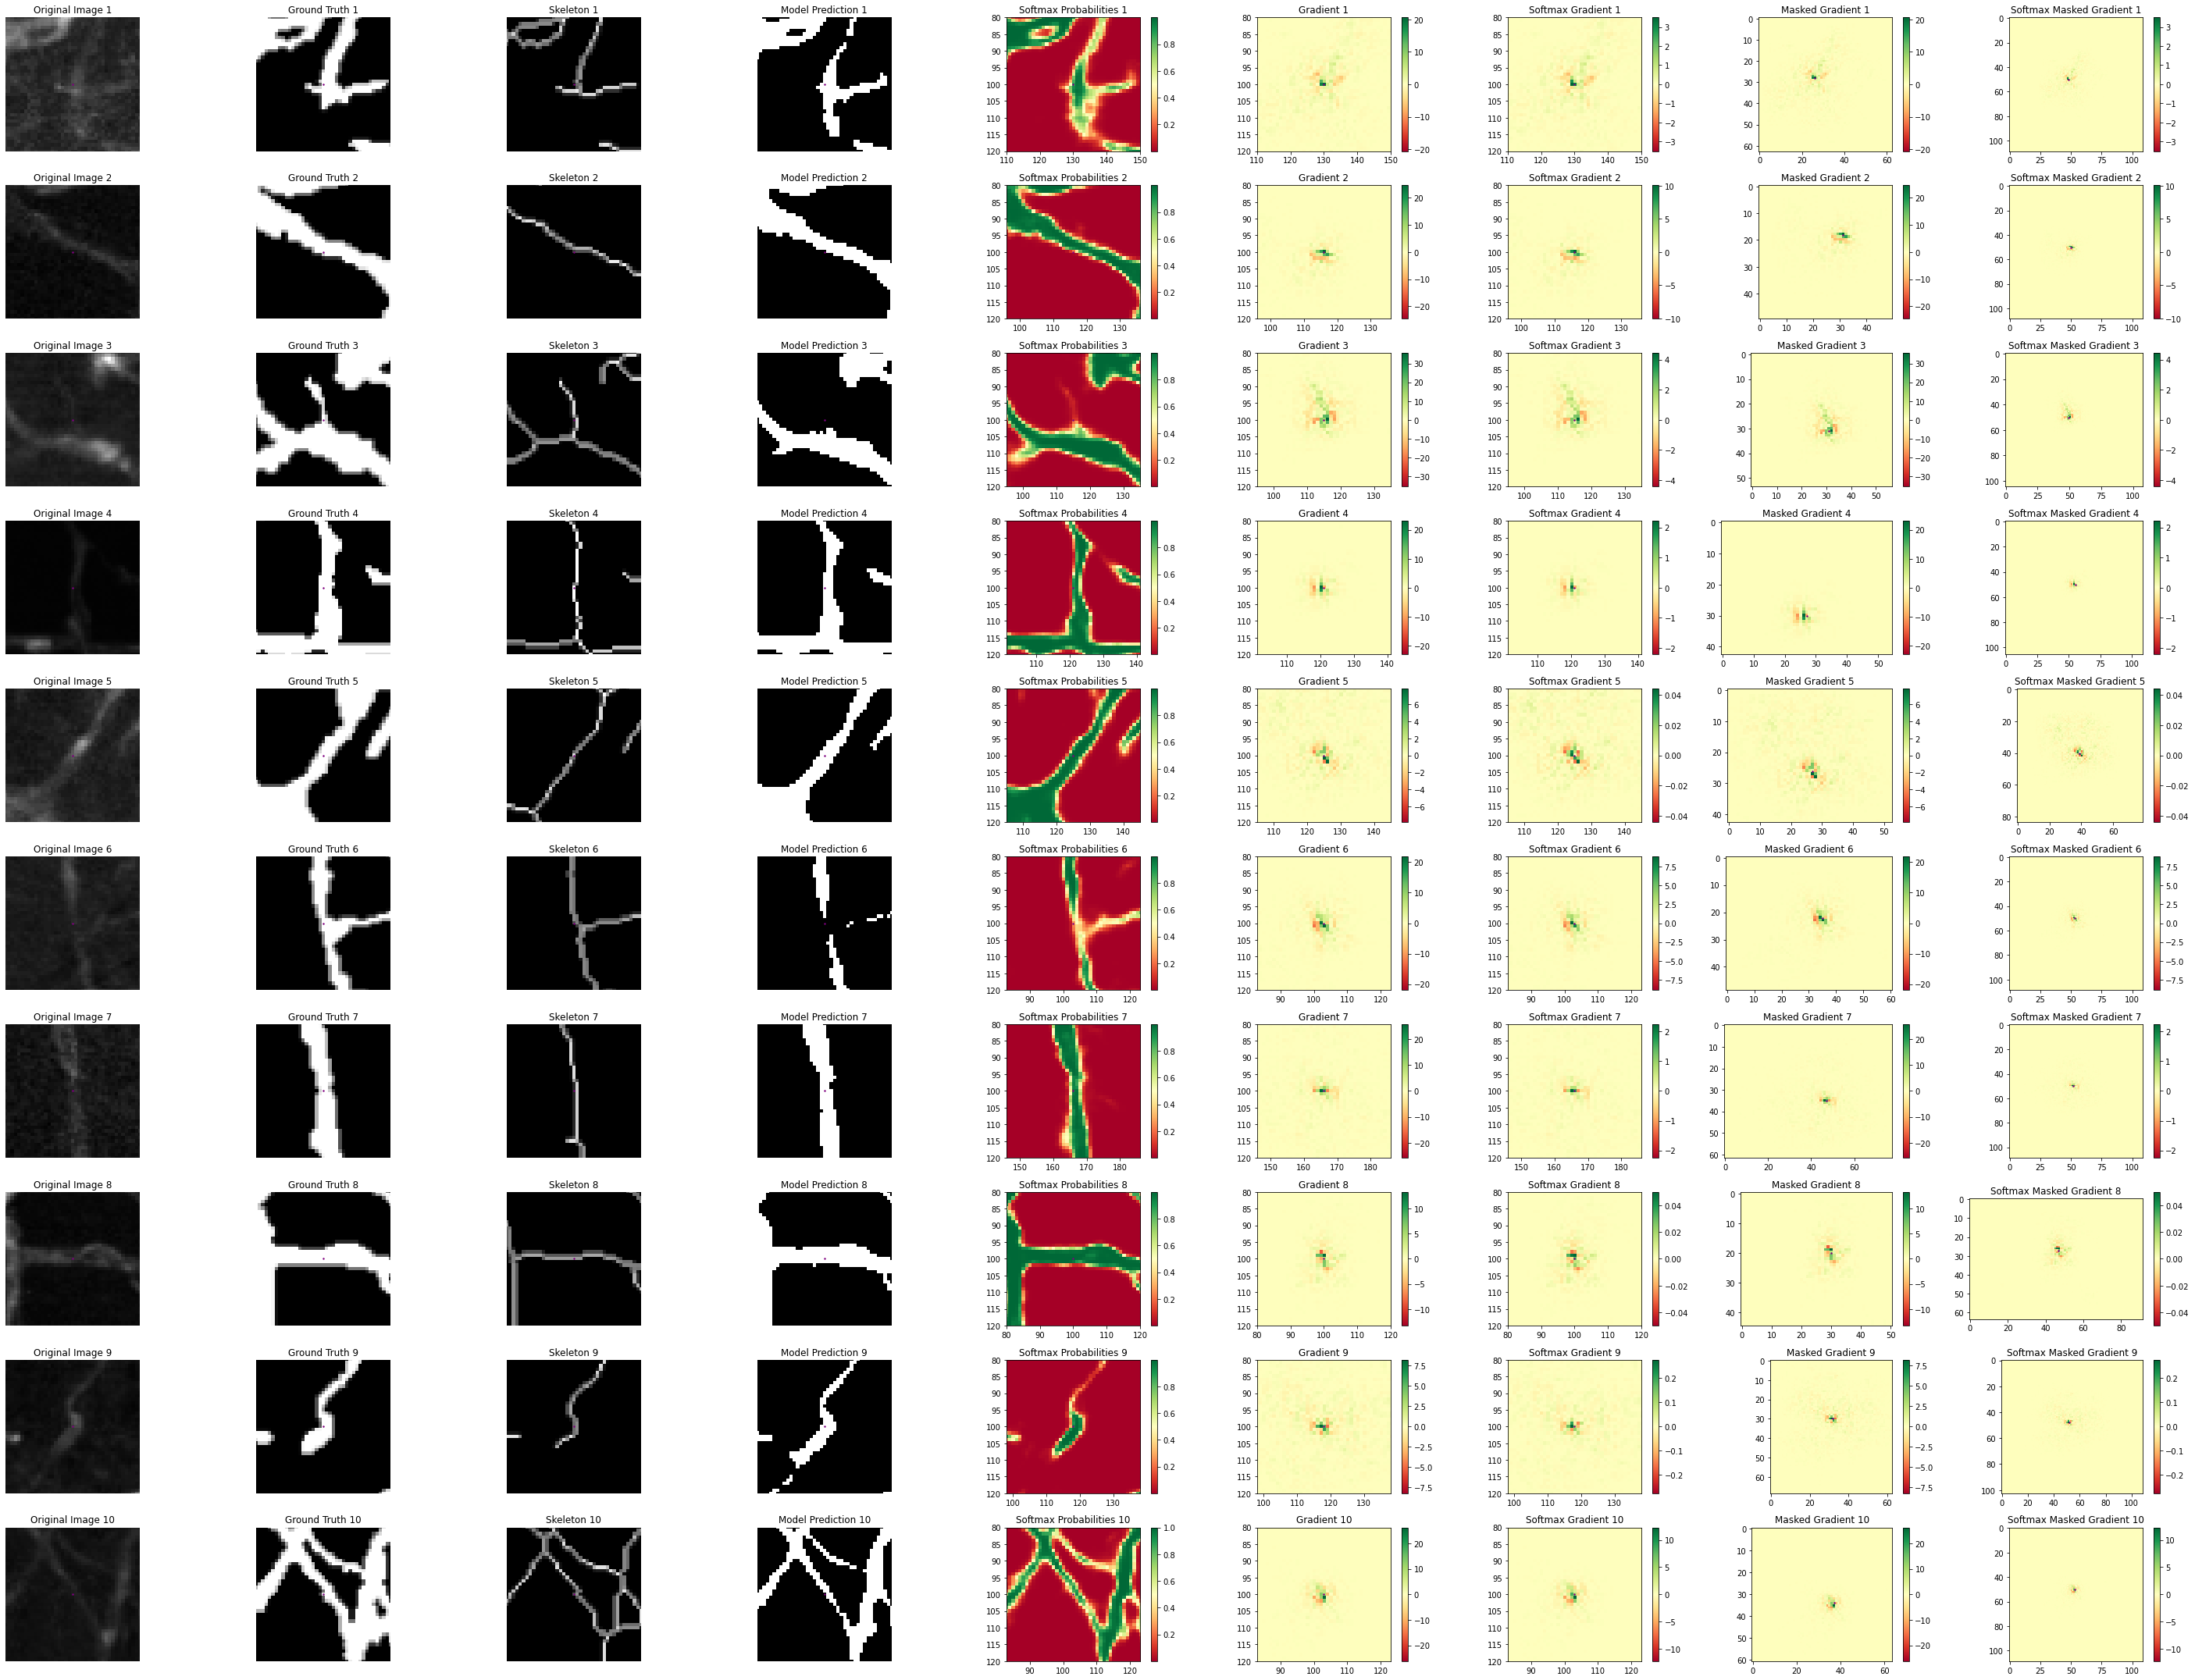

In [10]:
coordinates = []
soft_coordinates = []
# Iterate over all images
gradients = []
softmax_gradients = []
for i, img in enumerate(images):
    # Compute the gradient at the specified coordinates
    softmax_gradients.append(compute_softmax_gradient(model_regularized_l2, img, skeletons[i], soft_coordinates))
    gradients.append(compute_gradient_at_coordinates(model_regularized_l2, img, skeletons[i], coordinates))
    

num_images = len(gradients)

threshold = 0.1
soft_threshold = 0.0001


# Create a figure with 5 columns for each image: gradient, binary array, original image, and model output
fig, axes = plt.subplots(num_images, 9, figsize=(num_images * 4, num_images * 3))

for i in range(num_images):
    # Original Image Visualization
    original_img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    
    
    # Original Mask Visualization
    original_mask = masks[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 1].imshow(original_mask, cmap='gray')
    axes[i, 1].set_title(f'Ground Truth {i+1}')
    
    # Original Skeleton Visualization
    original_ske = skeletons[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 2].imshow(original_ske, cmap='gray')
    axes[i, 2].set_title(f'Skeleton {i+1}')
    

    # Model (Mask)Output Visualization
    output = model_regularized_l2(images[i].unsqueeze(0))  
    out_max = torch.argmax(output, dim=1, keepdim=True)
    model_mask = out_max[0].detach().cpu().numpy()
    axes[i, 3].imshow(model_mask.transpose(1, 2, 0), cmap='gray')
    axes[i, 3].set_title(f'Model Prediction {i+1}')
    
    # Softmax Probabilities Visualization
    output = model(images[i].unsqueeze(0))  
    softmax_probs = F.softmax(output, dim=1)
    class_one_probs = softmax_probs[0, 1, :, :].detach().cpu().numpy()
    img_softmax = axes[i, 4].imshow(class_one_probs, cmap='RdYlGn', interpolation='nearest')
    axes[i, 4].set_title(f'Softmax Probabilities {i+1}')
    
    # Gradient Visualization
    gradient = gradients[i].squeeze()
    v_max = np.abs(gradient.detach().cpu().numpy()).max()

    img_grad = axes[i, 5].imshow(gradient.detach().cpu().numpy(), cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 5].set_title(f'Gradient {i+1}')
    
    
    # Softmax Gradient Visualization
    softmax_gradient = softmax_gradients[i].squeeze()
    v_max = np.abs(softmax_gradient.detach().cpu().numpy()).max()

    soft_img_grad = axes[i, 6].imshow(softmax_gradient.detach().cpu().numpy(), cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 6].set_title(f'Softmax Gradient {i+1}')
    
    
    # Create a mask where gradient values are above the threshold
    mask = np.abs(gradient.detach().cpu().numpy()) > threshold
    # Find the bounds of the relevant region
    non_zero_coords = np.nonzero(mask)
    # Getting coordinates
    y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
    x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
    relevant_region = gradient[y_min:y_max+1, x_min:x_max+1].detach().cpu().numpy()
    v_max = np.abs(relevant_region).max()
    img_masked_grad = axes[i, 7].imshow(relevant_region, cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')
    axes[i, 7].set_title(f'Masked Gradient {i+1}')


    # Create a mask where gradient values are above the threshold
    soft_mask = np.abs(softmax_gradient.detach().cpu().numpy()) > soft_threshold
    # Find the bounds of the relevant region
    soft_non_zero_coords = np.nonzero(soft_mask)
    # Getting coordinates
    soft_y_min, soft_y_max = soft_non_zero_coords[0].min(), soft_non_zero_coords[0].max()
    soft_x_min, soft_x_max = soft_non_zero_coords[1].min(), soft_non_zero_coords[1].max()
    soft_relevant_region = softmax_gradient[soft_y_min:soft_y_max+1, soft_x_min:soft_x_max+1].detach().cpu().numpy()
    soft_v_max = np.abs(soft_relevant_region).max()
    soft_img_masked_grad = axes[i, 8].imshow(soft_relevant_region, cmap='RdYlGn', vmin=-soft_v_max, vmax=soft_v_max, interpolation='nearest')
    axes[i, 8].set_title(f'Softmax Masked Gradient {i+1}')

    # Highlight the specified pixel and zoom in
    coord = coordinates[i]
    for ax in axes[i, :7]:
        ax.scatter(coord[1], coord[0], color='purple', s=2)
        ax.set_xlim((coord[1] - 20, coord[1] + 20))
        ax.set_ylim((coord[0] + 20, coord[0] - 20))

    for ax in axes[i, :4]:
        ax.axis('off')
        
    # Scatter on masked gradient
    soft_coord = soft_coordinates[i]
    axes[i, 7].scatter(coord[1] - x_min, coord[0] - y_min, color='purple', s=2)
    axes[i, 8].scatter(soft_coord[1] - soft_x_min, soft_coord[0] - soft_y_min, color='purple', s=2)
    
    
    # Add colorbars
    fig.colorbar(img_softmax, ax=axes[i, 4], orientation='vertical')
    fig.colorbar(img_grad, ax=axes[i, 5], orientation='vertical')
    fig.colorbar(soft_img_grad, ax=axes[i, 6], orientation='vertical')
    fig.colorbar(img_masked_grad, ax=axes[i, 7], orientation='vertical')
    fig.colorbar(soft_img_masked_grad, ax=axes[i, 8], orientation='vertical')
    
plt.tight_layout()
plt.show()